In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

!ls {PATH}

20_words.csv		     paragraphs.csv
ascii			     paragraphs_df.csv
chars.csv		     paragraphs.tar.gz
large_synth_word_ids.csv     square_lines
large_synth_words	     square_lines.tgz
large_synth_words.csv	     synth_word_ids.csv
line_chars.csv		     synth_words
line_labels.csv		     synth_words_50000.csv
lines			     synth_words.csv
lines.tgz		     testing_multi_synth_words
models			     tmp
multi_synth_word_ids.csv     word_char_ids.csv
multi_synth_words	     word_labels.csv
multi_synth_words_50000.csv  words
multi_synth_words.csv	     words_chars.csv
multi_synth_words.tgz	     words.csv
paragraph_chars.csv	     words.tgz
paragraphs


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Synthesize Data

In [5]:
def standardize_imgs(imgs, baseheight):
    resized_imgs = []
    for img in imgs:
        hpercent = (baseheight / float(img.size[1]))
        wsize = int((float(img.size[0]) * float(hpercent)))
        img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)
        resized_imgs.append(img)
    return resized_imgs

### pd.read_csv

In [105]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)

In [106]:
len(df)

75597

In [107]:
# remove errors
df = df[df.result != 'err']

In [108]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [109]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [110]:
df = df.loc[df['char_len'] > 3]

In [111]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
4,a01-000u-01-02,ok,more,4
5,a01-000u-01-03,ok,Labour,6


### manually created df

In [19]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
samples = np.stack(samples)
df = pd.DataFrame(samples, columns=['filename', 'word', 'char_len'], )
del samples

In [20]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### specify number of words/image

In [73]:
def create_img(files, fname, sz=None, pad=30):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[0]
    h = sz[1]
        
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
        
    new_im.save(synth_path/fname)

#### Create Data

In [201]:
!rm -rf {synth_path}
synth_path = PATH/'testing_multi_synth_words'

# synth_path = PATH/'multi_synth_words'

os.makedirs(synth_path, exist_ok=True)

In [75]:
# number of words/image
def create_synth_data(num, sz, offset=0):
    samp = np.product(sz)
    d={}
    for i in range(num):
        res = df.sample(samp)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:04d}'.format(i+offset)+'.png'
        create_img(files, fname, sz)
        d[fname] = label
    return d

d = create_synth_data(10, (4,6))
len(d)

10

In [198]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,volume before owed through with produced coupl...
1,0001.png,French black very Last stead successful public...
2,0002.png,PRINTED here oscillations take 1/2-in.-long th...
3,0003.png,were this careful taking Richardson Monday sen...
4,0004.png,"cannot ball carried watching Prince 1,409 chai..."


### specify size of image

In [8]:
def create_img(sz, fname, pad=30):
    # TODO: randomize padding
    new_im = Image.new('RGB', (sz,sz), color=(255,255,255))
    
    res   = df.sample(30)
    files = list(map(lambda x: x+'.png', res.filename.values))
    lbls  = res.word.values.tolist()
    imgs  = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    w, h  = zip(*(i.size for i in imgs))

    # standardize heights and sort longest to shortest words
    median_height = int(np.median(h))        # TODO: randomize this between mean/std
    stzd_imgs = standardize_imgs(imgs, median_height)
    
    #loop through standardized images and find the next image which satisfies the condition
    labels = []
    y_offset = pad
    while y_offset+median_height+pad < sz:        
        x_offset = pad
        
        gen = (i for i,x in enumerate(stzd_imgs) if x.size[0]+x_offset+pad <= sz)
        for idx in gen:
            word = stzd_imgs.pop(idx)            
            labels.append(lbls.pop(idx))
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height+pad

    new_im.save(synth_path/fname)
    return ' '.join(labels)

#### Create Data

In [26]:
# for testing
synth_path = PATH/'testing_synth_words'
!rm -rf {synth_path}

os.makedirs(synth_path, exist_ok=True)

In [27]:
# for realz
synth_path = PATH/'large_synth_words'

In [28]:
# size of image
def create_synth_data(qty, sz, fname_offset=0):
    d={}
    for i in range(qty):
        fname = '{:04d}'.format(i+fname_offset)+'.png'
        d[fname] = create_img(sz, fname)
    return d

d = create_synth_data(5000, 1000, fname_offset=5000)
len(d)

# ~25min to create 5000 1000x1000 images

5000

In [29]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,5000.png,Master revived with frontlets tiger force moul...
1,5001.png,jobs plan 1superceded meet about offer about f...
2,5002.png,This Chambre ingenuity wives social public lit...
3,5003.png,that world held minds prepared room heading su...
4,5004.png,some fixed sails have tenure upper have showed...


### Verify

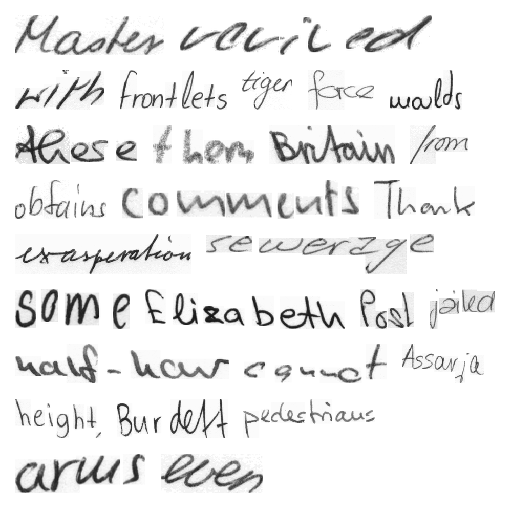

In [32]:
# check resizing
im = Image.open(synth_path/'5000.png')
im.resize((512,512))

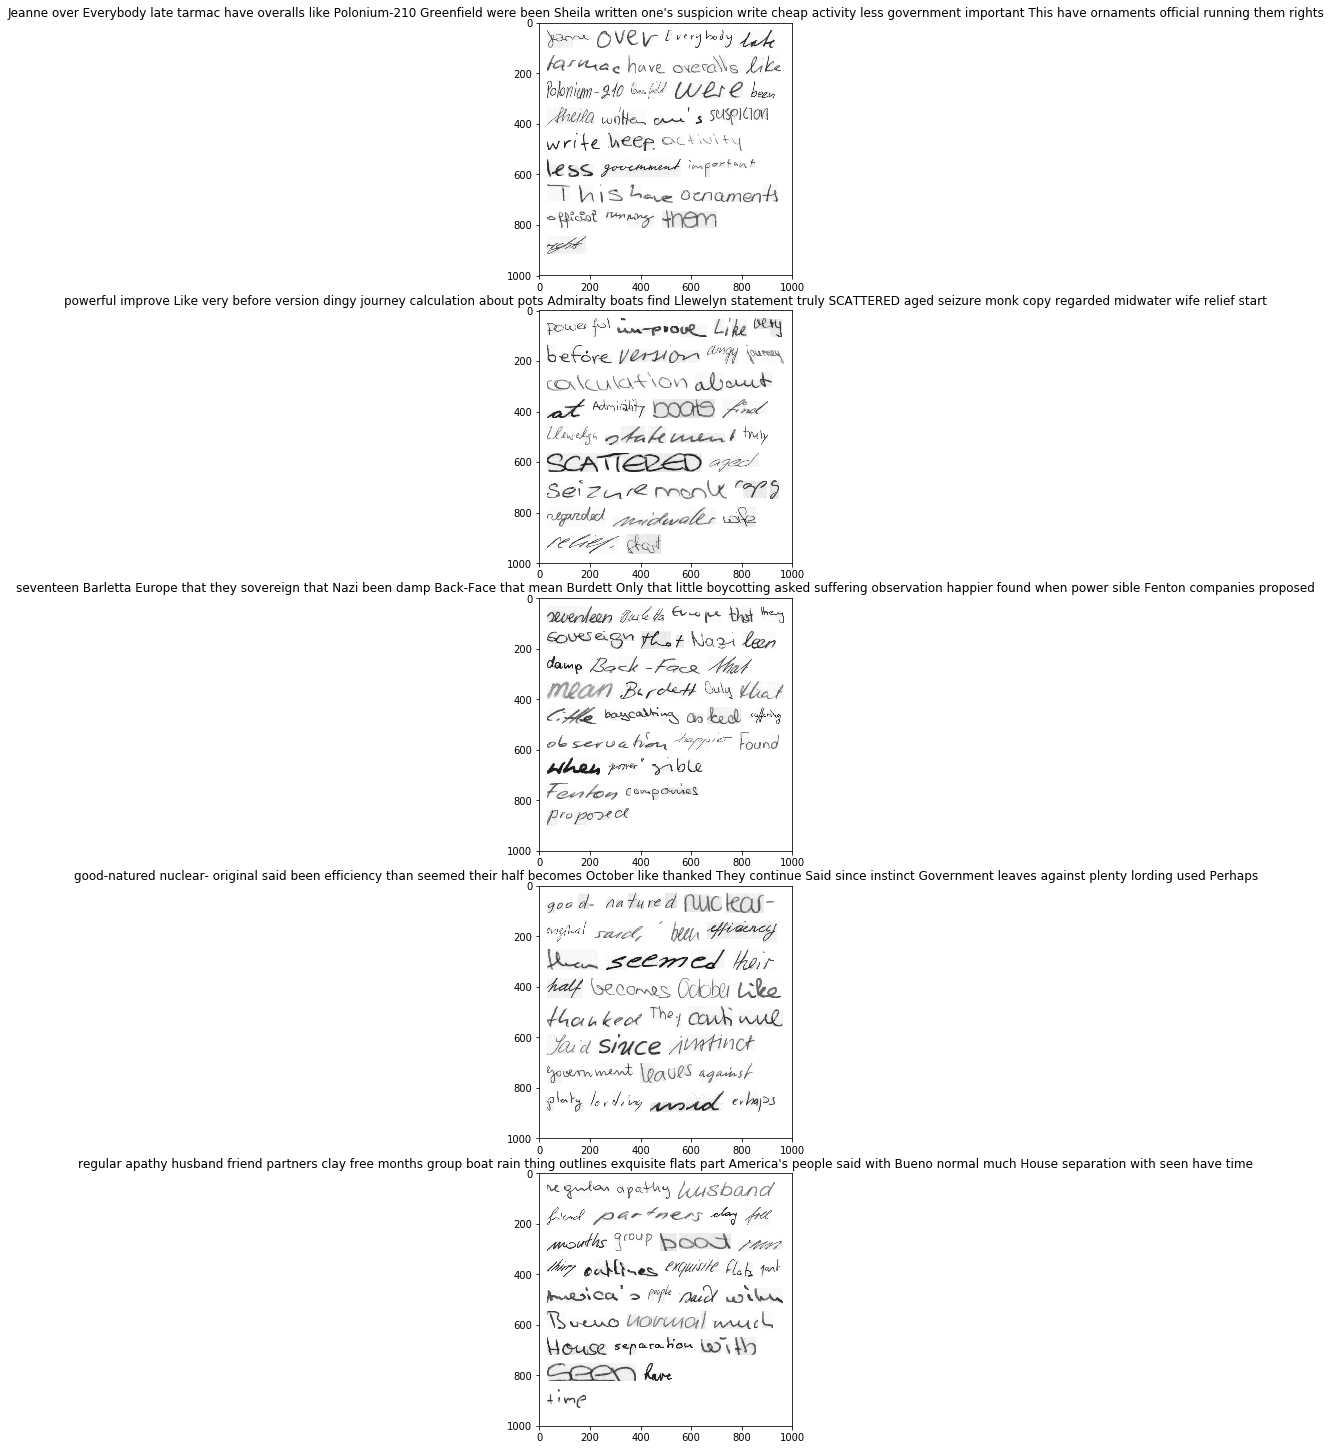

In [15]:
fig, axes = plt.subplots(5,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(row.labels)
    
plt.tight_layout(pad=0.2)

## Numericalize characters

In [33]:
# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))
len(itos)

82

In [34]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [36]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,5000.png,Master revived with frontlets tiger force moul...,42 56 74 75 60 73 1 73 60 77 64 77 60 59 1 78 ...
1,5001.png,jobs plan 1superceded meet about offer about f...,65 70 57 74 1 71 67 56 69 1 18 74 76 71 60 73 ...
2,5002.png,This Chambre ingenuity wives social public lit...,49 63 64 74 1 32 63 56 68 57 73 60 1 64 69 62 ...
3,5003.png,that world held minds prepared room heading su...,75 63 56 75 1 78 70 73 67 59 1 63 60 67 59 1 6...
4,5004.png,some fixed sails have tenure upper have showed...,74 70 68 60 1 61 64 79 60 59 1 74 56 64 67 74 ...


In [21]:
# CSV = PATH/'large_synth_words_sample.csv'
# synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

### Add to existing CSV

In [39]:
CSV = PATH/'large_synth_words.csv'
csv = pd.read_csv(CSV)

In [41]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_words_10000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [42]:
len(new)

10000

## Numericalize words

In [47]:
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))
len(itos)

5902

In [52]:
joined_labels = list(synth.labels)

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [53]:
synth['word_ids'] = str_ids
synth.head()

,filename,labels,char_ids,word_ids
0,5000.png,Master revived with frontlets tiger force moul...,42 56 74 75 60 73 1 73 60 77 64 77 60 59 1 78 ...,4645 4811 5 2 2 1702 1380 18 22 128 8 2 3023 4...
1,5001.png,jobs plan 1superceded meet about offer about f...,65 70 57 74 1 71 67 56 69 1 18 74 76 71 60 73 ...,1063 519 707 328 20 380 20 1583 565 1045 2 443...
2,5002.png,This Chambre ingenuity wives social public lit...,49 63 64 74 1 32 63 56 68 57 73 60 1 64 69 62 ...,34 574 2 1505 775 280 60 10 516 2 2423 302 399...
3,5003.png,that world held minds prepared room heading su...,75 63 56 75 1 78 70 73 67 59 1 63 60 67 59 1 6...,4 209 315 742 317 276 2 2486 949 7 268 560 11 ...
4,5004.png,some fixed sails have tenure upper have showed...,74 70 68 60 1 61 64 79 60 59 1 74 56 64 67 74 ...,31 1082 1768 7 2 1375 7 682 103 186 1306 147 1...


### Add to existing CSV

In [60]:
CSV = PATH/'large_synth_word_ids_10000.csv'
csv = pd.read_csv(CSV)

In [58]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_word_ids_10000.csv'

new = pd.concat([csv, synth[['filename', 'word_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

In [59]:
len(new)

10000

In [61]:
csv.word_ids[4888:5005]

4888    282 317 107 561 4368 2702 55 2330 541 2807 336...
4889    1114 39 3984 162 1689 1316 5888 2803 284 5005 ...
4890    2 386 2611 2 317 225 451 61 180 1095 152 155 1...
4891    1521 991 349 759 535 43 751 4341 2 2240 2 6 23...
4892    2 1266 4459 1175 60 251 103 92 1020 62 404 4 3...
4893    3350 899 14 1726 972 155 360 417 12 269 2 226 ...
4894    404 6 3558 60 66 108 3818 2 137 24 212 1077 24...
4895    1884 4 456 192 764 2 718 563 2862 3629 3449 69...
4896    16 72 93 1087 1918 116 2860 2 543 782 15 817 5...
4897    13 550 3364 34 2664 2681 3294 4 2 450 21 2 152...
4898    103 466 146 168 494 8 6 3686 732 2276 769 204 ...
4899    2 11 37 1220 2 2463 8 691 1507 526 239 1950 48...
4900    5326 35 83 208 2 26 2 2155 2990 374 2116 4219 ...
4901    2 708 386 40 247 66 564 4022 21 1576 2 1295 82...
4902    74 1398 13 12 2980 223 535 580 1073 70 697 583...
4903    9 8 3891 162 2506 4654 635 1217 143 288 118 2 ...
4904    475 47 2188 781 50 608 239 976 2 445 287 16 77...
4905    2 105 

### Modify csv/itos to match previous versions

In [63]:
itos_old = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [64]:
res = [''.join([itos_old[int(c)] for c in line.split(' ')]) for line in csv.char_ids]
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...,lace- death four warily considerably without
1,0001.png,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...,food twentieth Western been proved Rhodesia
2,0002.png,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...,task choice being longshore which childless
3,0003.png,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...,advisers that GENERAL were false example
4,0004.png,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...,especially That step rolls know been


In [65]:
joined_labels = list(csv.words) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]+[3]) for word in joined_labels])

In [66]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [72]:
csv['char_ids'] = str_ids
csv = csv[['filename', 'char_ids']]
csv.head()

,filename,char_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...


### Verify

In [31]:
def label_text(pred):
#     ints = to_np(pred).astype(int)
#     ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[int(i)] for i in pred])

ValueError: left cannot be >= right

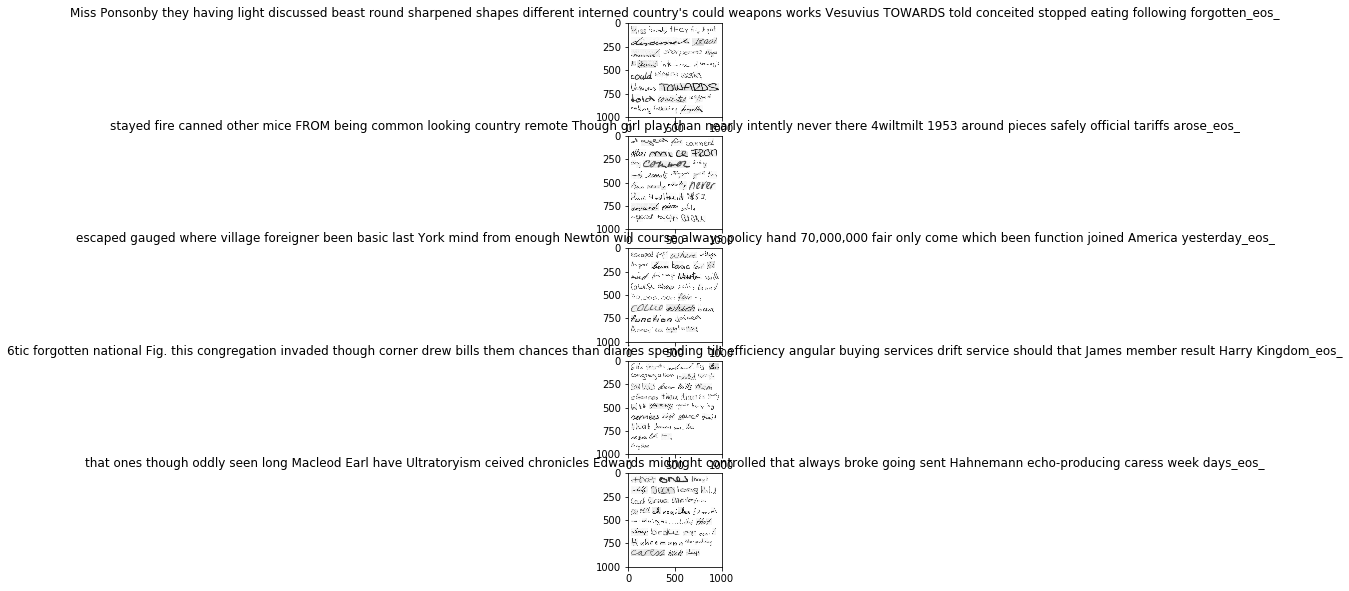

In [34]:
fig, axes = plt.subplots(5,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(label_text(row.char_ids.split(' ')))
    
plt.tight_layout(pad=0.2)